Конфигурация сети:
  Входной слой: 784 нейронов
  Скрытый слой: 300 нейронов
  Выходной слой: 10 нейронов
  Скорость обучения: 0.1
  Размер батча: 64
  Количество эпох: 20
Загрузка MNIST dataset...
Размеры данных:
  Обучающая выборка: (60000, 784)
  Тестовая выборка: (10000, 784)
Демонстрация изображений из обучающей выборки:


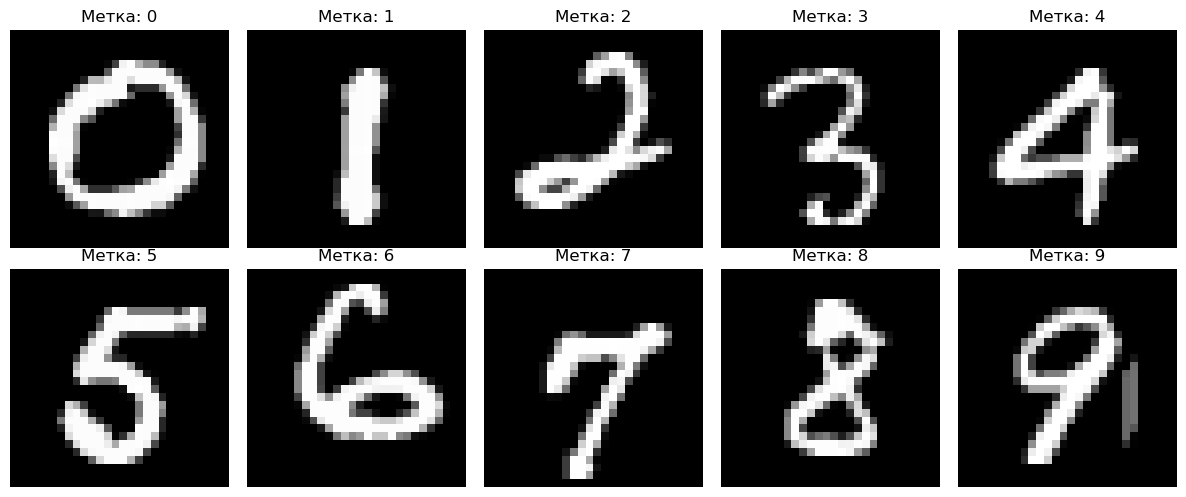

Инициализация нейронной сети...
Начало обучения...
Эпоха 1/20:
  Потери (обучение): 0.3572, Точность: 0.9021
  Потери (валидация): 0.2269, Точность: 0.9329
  Время: 6.55 сек
--------------------------------------------------
Эпоха 2/20:
  Потери (обучение): 0.1862, Точность: 0.9468
  Потери (валидация): 0.1681, Точность: 0.9511
  Время: 6.55 сек
--------------------------------------------------
Эпоха 3/20:
  Потери (обучение): 0.1373, Точность: 0.9612
  Потери (валидация): 0.1284, Точность: 0.9632
  Время: 6.88 сек
--------------------------------------------------
Эпоха 4/20:
  Потери (обучение): 0.1086, Точность: 0.9695
  Потери (валидация): 0.1145, Точность: 0.9666
  Время: 7.08 сек
--------------------------------------------------
Эпоха 5/20:
  Потери (обучение): 0.0904, Точность: 0.9744
  Потери (валидация): 0.1000, Точность: 0.9689
  Время: 6.94 сек
--------------------------------------------------
Эпоха 6/20:
  Потери (обучение): 0.0770, Точность: 0.9780
  Потери (валидация):

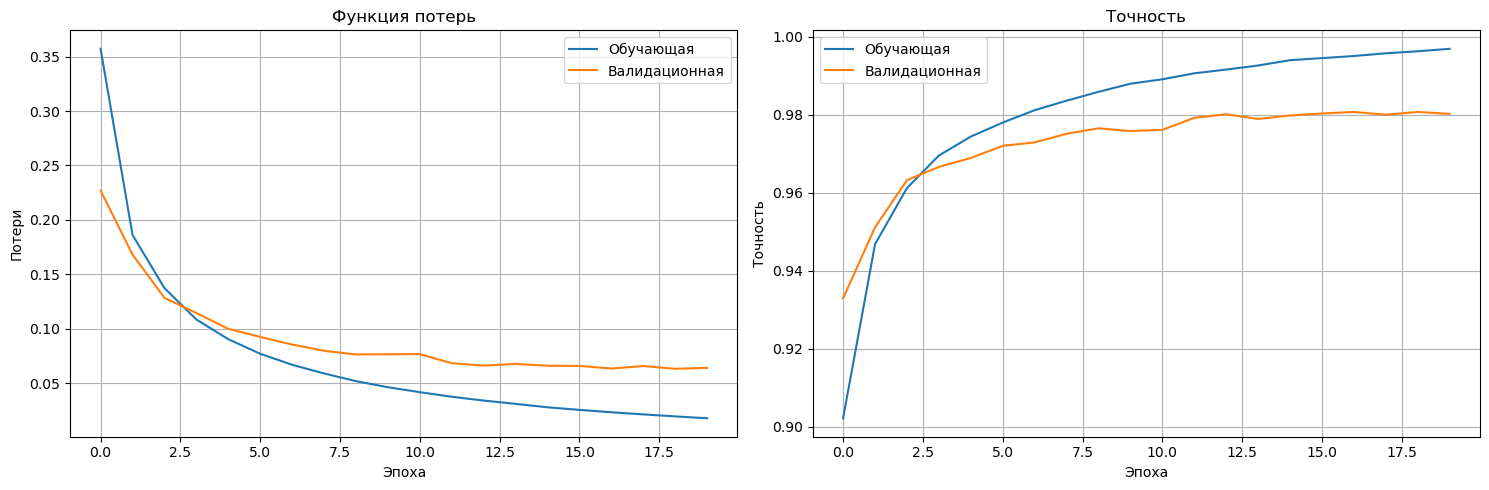

Демонстрация предсказаний на тестовой выборке:


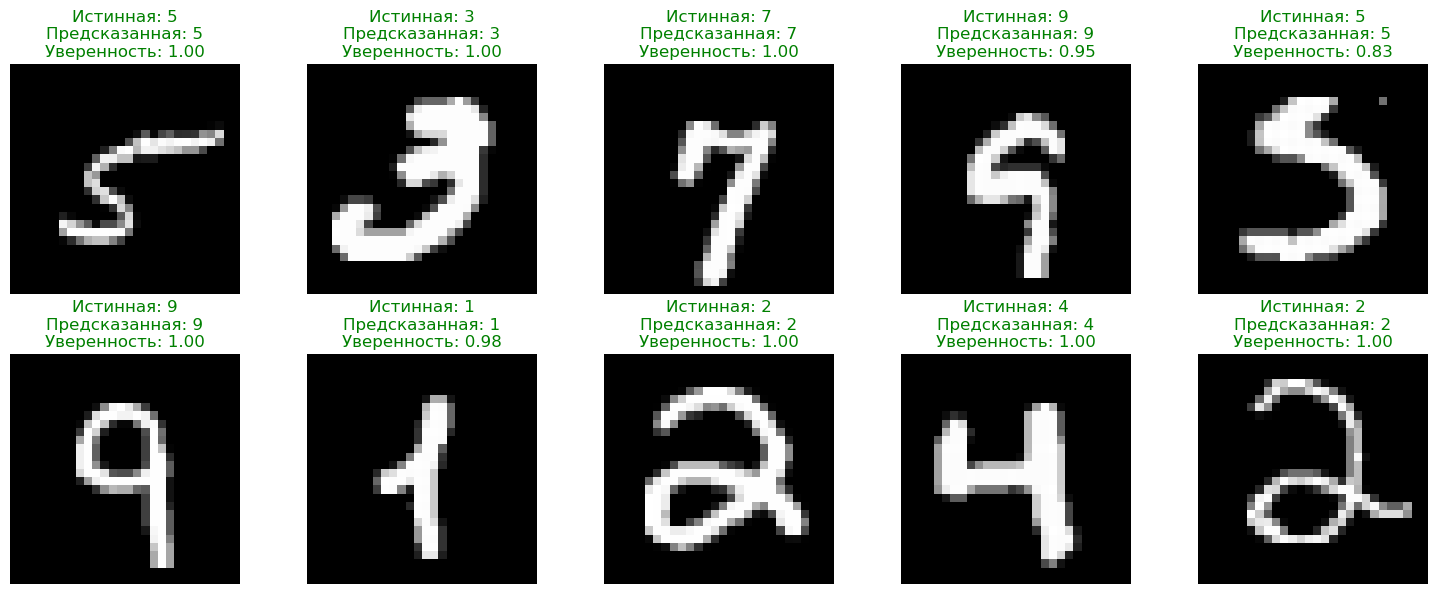

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import time


def load_mnist():
    print("Загрузка MNIST dataset...")
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    X = mnist.data.astype(np.float32)
    y = mnist.target.astype(np.int32)
    
    X = X / 255.0

    y_one_hot = np.eye(10)[y]
    
    X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(
        X, y_one_hot, y, test_size=10000, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test, y_train_labels, y_test_labels

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(np.float32)

def softmax(x):
    #exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def accuracy(y_pred, y_true):
    predictions = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_true, axis=1)
    return np.mean(predictions == true_labels)

class TwoLayerNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        
    def forward(self, X):
        """Прямой проход"""
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = softmax(self.z2)
        return self.a2
    
    def backward(self, X, y, output):
        m = X.shape[0]
        
        dz2 = output - y
        dW2 = (1/m) * np.dot(self.a1.T, dz2)
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
        
        dz1 = np.dot(dz2, self.W2.T) * relu_derivative(self.z1)
        dW1 = (1/m) * np.dot(X.T, dz1)
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)

        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
    
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        train_loss_history = []
        val_loss_history = []
        train_acc_history = []
        val_acc_history = []
        
        n_batches = len(X_train) // batch_size
        
        for epoch in range(epochs):
            start_time = time.time()
            epoch_train_loss = 0
            epoch_train_acc = 0
            
            indices = np.random.permutation(len(X_train))
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            for i in range(n_batches):
                start_idx = i * batch_size
                end_idx = start_idx + batch_size
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                
                output = self.forward(X_batch)
                
                batch_loss = cross_entropy_loss(output, y_batch)
                batch_acc = accuracy(output, y_batch)
                
                epoch_train_loss += batch_loss
                epoch_train_acc += batch_acc
                
                self.backward(X_batch, y_batch, output)
            
            avg_train_loss = epoch_train_loss / n_batches
            avg_train_acc = epoch_train_acc / n_batches
            
            val_output = self.forward(X_val)
            val_loss = cross_entropy_loss(val_output, y_val)
            val_acc = accuracy(val_output, y_val)
            
            train_loss_history.append(avg_train_loss)
            val_loss_history.append(val_loss)
            train_acc_history.append(avg_train_acc)
            val_acc_history.append(val_acc)
            
            epoch_time = time.time() - start_time
            
            print(f"Эпоха {epoch+1}/{epochs}:")
            print(f"  Потери (обучение): {avg_train_loss:.4f}, Точность: {avg_train_acc:.4f}")
            print(f"  Потери (валидация): {val_loss:.4f}, Точность: {val_acc:.4f}")
            print(f"  Время: {epoch_time:.2f} сек")
            print("-" * 50)
        
        return train_loss_history, val_loss_history, train_acc_history, val_acc_history

def main():
    input_size = 784  # 28x28
    hidden_size = 300
    output_size = 10
    learning_rate = 0.1
    batch_size = 64
    epochs = 20
    
    print("Конфигурация сети:")
    print(f"  Входной слой: {input_size} нейронов")
    print(f"  Скрытый слой: {hidden_size} нейронов")
    print(f"  Выходной слой: {output_size} нейронов")
    print(f"  Скорость обучения: {learning_rate}")
    print(f"  Размер батча: {batch_size}")
    print(f"  Количество эпох: {epochs}")
    print("=" * 50)
    
    X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = load_mnist()
    
    print(f"Размеры данных:")
    print(f"  Обучающая выборка: {X_train.shape}")
    print(f"  Тестовая выборка: {X_test.shape}")
    
    def show_sample_images():
        fig, axes = plt.subplots(2, 5, figsize=(12, 5))
        for i in range(10):
            row, col = i // 5, i % 5
            idx = np.where(y_train_labels == i)[0][0]
            axes[row, col].imshow(X_train[idx].reshape(28, 28), cmap='gray')
            axes[row, col].set_title(f'Метка: {y_train_labels[idx]}')
            axes[row, col].axis('off')
        plt.tight_layout()
        plt.show()
    
    print("Демонстрация изображений из обучающей выборки:")
    show_sample_images()
    
    print("Инициализация нейронной сети...")
    model = TwoLayerNeuralNetwork(input_size, hidden_size, output_size, learning_rate)
    
    print("Начало обучения...")
    train_loss, val_loss, train_acc, val_acc = model.train(
        X_train, y_train, X_test, y_test, epochs, batch_size
    )
    
    test_output = model.forward(X_test)
    test_accuracy = accuracy(test_output, y_test)
    test_loss = cross_entropy_loss(test_output, y_test)
    
    print("=" * 50)
    print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")
    print(f"Потери на тестовой выборке: {test_loss:.4f}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Обучающая')
    plt.plot(val_loss, label='Валидационная')
    plt.title('Функция потерь')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Обучающая')
    plt.plot(val_acc, label='Валидационная')
    plt.title('Точность')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    def show_predictions():
        n_samples = 10
        indices = np.random.choice(len(X_test), n_samples, replace=False)
        
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        for i, idx in enumerate(indices):
            row, col = i // 5, i % 5
            image = X_test[idx].reshape(28, 28)
            true_label = y_test_labels[idx]
            
            # Предсказание
            prediction = model.forward(X_test[idx:idx+1])
            pred_label = np.argmax(prediction[0])
            confidence = np.max(prediction[0])
            
            axes[row, col].imshow(image, cmap='gray')
            color = 'green' if true_label == pred_label else 'red'
            axes[row, col].set_title(f'Истинная: {true_label}\nПредсказанная: {pred_label}\nУверенность: {confidence:.2f}', 
                                   color=color)
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    print("Демонстрация предсказаний на тестовой выборке:")
    show_predictions()

if __name__ == "__main__":
    main()

In [2]:
print(m)

NameError: name 'm' is not defined

In [3]:
    print("Загрузка MNIST dataset...")
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    X = mnist.data.astype(np.float32)
    y = mnist.target.astype(np.int32)
    
    X = X / 255.0

    y_one_hot = np.eye(10)[y]
    
    X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(
        X, y_one_hot, y, test_size=10000, random_state=42, stratify=y
    )
X.shape()

Загрузка MNIST dataset...


TypeError: 'tuple' object is not callable

In [6]:
X.shape[0]

70000

In [8]:
    input_size = 784  # 28x28
    hidden_size = 300
    output_size = 10
    learning_rate = 0.1
    batch_size = 64
    epochs = 20
    
    print("Конфигурация сети:")
    print(f"  Входной слой: {input_size} нейронов")
    print(f"  Скрытый слой: {hidden_size} нейронов")
    print(f"  Выходной слой: {output_size} нейронов")
    print(f"  Скорость обучения: {learning_rate}")
    print(f"  Размер батча: {batch_size}")
    print(f"  Количество эпох: {epochs}")
    print("=" * 50)
    
    X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = load_mnist()

Конфигурация сети:
  Входной слой: 784 нейронов
  Скрытый слой: 300 нейронов
  Выходной слой: 10 нейронов
  Скорость обучения: 0.1
  Размер батча: 64
  Количество эпох: 20
Загрузка MNIST dataset...


In [9]:
X_train.shape[0]

60000